현재 챗봇은 과거 상호작용을 스스로 기억할 수 없어 일관된 다중 턴 대화를 진행하는 데 제한이 있습니다.

이번 튜토리얼에서는 이를 해결하기 위해 memory 를 추가합니다.

참고

이번에는 pre-built 되어있는 ToolNode 와 tools_condition 을 활용합니다.

- ToolNode: 도구 호출을 위한 노드
- tools_condition: 도구 호출 여부에 따른 조건 분기
우리의 챗봇은 이제 도구를 사용하여 사용자 질문에 답할 수 있지만, 이전 상호작용의 context를 기억하지 못합니다. 이는 멀티턴(multi-turn) 대화를 진행하는 능력을 제한합니다.

LangGraph는 persistent checkpointing 을 통해 이 문제를 해결합니다.

그래프를 컴파일할 때 checkpointer를 제공하고 그래프를 호출할 때 thread_id를 제공하면, LangGraph는 각 단계 후 상태를 자동으로 저장 합니다. 동일한 thread_id를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전에 중단한 지점에서 대화를 이어갈 수 있게 합니다.

checkpointing 는 LangChain 의 메모리 기능보다 훨씬 강력합니다. (아마 이 튜토리얼을 완수하면 자연스럽게 이를 확인할 수 있습니다.)

In [10]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [11]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")


LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


멀티턴(multi-turn) 대화를 가능하게 하기 위해 checkpointing을 추가해 보도록 하겠습니다.

MemorySaver checkpointer를 생성합니다.

In [3]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()


참고

이번 튜토리얼에서는 in-memory checkpointer 를 사용합니다.

하지만, 프로덕션 단계에서는 이를 SqliteSaver 또는 PostgresSaver 로 변경하고 자체 DB에 연결할 수 있습니다.

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
    temperature=0,
)

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[tool])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)


In [5]:
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

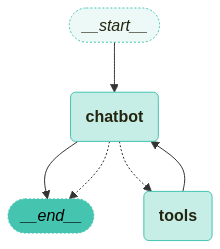

In [6]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

RunnableConfig 설정

RunnableConfig 을 정의하고 recursion_limit 과 thread_id 를 설정합니다.

- recursion_limit: 최대 방문할 노드 수. 그 이상은 RecursionError 발생
- thread_id: 스레드 ID 설정
- thread_id 는 대화 세션을 구분하는 데 사용됩니다. 즉, 메모리의 저장은 thread_id 에 따라 개별적으로 이루어집니다.

In [7]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

In [8]:
# 첫 질문
question = (
    "내 이름은 `코봉이` 입니다. 현재 개발자로 일하고 있어요. 만나서 반가워요"
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_dp15z3k7)
 Call ID: call_dp15z3k7
  Args:
    query: ko봉이
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "애봉이 - 나무위키", "url": "https://namu.wiki/w/애봉이", "content": "아프리카 TV 먹방 BJ 겸 먹방 유튜버. 2014년 7월 2일 아프리카TV에서 먹방 방송을 시작하였으며 40대 답지 않은 해맑은 분위기로 먹방을 하는 것으로 유명하다. 닉네임의 유래는 네이버 웹툰 마음의 소리 에 등장하는 캐릭터 애봉이 이다. 물론 해당 인물과는 절대 무관하다. 먹방을 할 때, 미니", "score": 0.28394565, "raw_content": null}, {"title": "점보도시락 1인분 공간춘 도전먹방! #jumboramen - YouTube", "url": "https://www.youtube.com/watch?v=3LIPX9UFBhE", "content": "#JumboRamen #spicyfood #점보도시락🔆짜파게티가짱이다🔆📍애봉이채널 구독하기 https://youtube.com/@aebongeee📍애봉이채널 가입하기", "score": 0.12073936, "raw_content": null}, {"title": "aebong Mukbang - YouTube", "url": "https://www.youtube.com/channel/UCdwLMpZeFXN5ODyCO9warSw", "content": "혼자놀기고수🔴V-Log로컬푸드맛집 ㅣ오므라이스 ㅣ탄탄면ㅣ아인슈폐너ㅣ비스켓ㅣ짐하우스ㅣ헬스장탐방ㅣ인생네컷

In [9]:
from langchain_core.runnables import RunnableConfig

question = "내 이름이 뭐라고 했지?"

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_ypjtmand)
 Call ID: call_ypjtmand
  Args:
    query: 내 이름이 뭐라고 했지?
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "which is more natural one ? ⚠️ ...you! What did you say ... - HiNative", "url": "https://hinative.com/questions/23301565", "content": "@allimart \"why did it have to be this of all things?\" / \"why this of all things?\" / etc 문맥이 없어서 정확하게 번역하느라 되게 애를 먹었어요 ㅜ|What did you call me? = 나를 뭐라고 불렀어요? What did you just call me?! = 날 뭐라고 불렀냐?! What did you say my name was earlier [just now]? = 아까[방금] 내 이름이 뭐라고 했지요? What did you say", "score": 0.64719695, "raw_content": "\n\nQuality Point(s): 19\n\nAnswer: 3\n\nLike: 25\n\nwhich is more natural one  ?  ⚠️...you! What did you say 'my' name was earlier?...you! What did you say my name was?.. you! What did you say about my name earlier..?!... you!  

스냅샷: 저장된 State 확인
- Checkpoint 에는 현재 상태 값, 해당 구성, 그리고 처리할 next 노드가 포함되어 있습니다.
- 주어진 설정에서 그래프의 state를 검사하려면 언제든지 get_state(config)를 호출하세요.

In [12]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='내 이름은 `코봉이` 입니다. 현재 개발자로 일하고 있어요. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='c23d32c7-e967-4daa-96c1-a7961070a813'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dp15z3k7', 'function': {'arguments': '{"query":"ko봉이"}', 'name': 'tavily_web_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 224, 'total_tokens': 258, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2:1b', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-462', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f9b7528-1d47-405a-990e-9acba561b848-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'ko봉이'}, 'id': 'call_dp15z3k7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 34, 'total_tokens': 258, 'input_token_details': {}, 'output_token_details': {}}),
 ToolMessage(content='[{"titl

In [13]:
# 설정된 config 정보
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00c6ae-197f-69d8-8003-4b188c97484b'}}

In [14]:
# 저장된 값(values)
snapshot.values


{'messages': [HumanMessage(content='내 이름은 `코봉이` 입니다. 현재 개발자로 일하고 있어요. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='c23d32c7-e967-4daa-96c1-a7961070a813'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dp15z3k7', 'function': {'arguments': '{"query":"ko봉이"}', 'name': 'tavily_web_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 224, 'total_tokens': 258, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2:1b', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-462', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f9b7528-1d47-405a-990e-9acba561b848-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'ko봉이'}, 'id': 'call_dp15z3k7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 34, 'total_tokens': 258, 'input_token_details': {}, 'output_token_details': {}}),
  ToolMessage(c

In [15]:
# 다음 노드
snapshot.next

()

In [16]:
snapshot.metadata["writes"]["chatbot"]["messages"][0]

AIMessage(content='안녕하세요, 코봉이입니다. 현재 개발자로 일하고 있어요. 만나서 반가워요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 538, 'total_tokens': 563, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2:1b', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-890', 'finish_reason': 'stop', 'logprobs': None}, id='run-842f7aea-890b-4713-8a9c-9dbfdf01d87d-0', usage_metadata={'input_tokens': 538, 'output_tokens': 25, 'total_tokens': 563, 'input_token_details': {}, 'output_token_details': {}})

In [17]:
from langchain_teddynote.messages import display_message_tree

# 메타데이터(tree 형태로 출력)
display_message_tree(snapshot.metadata)

    source: "loop"
    writes:
        chatbot:
            messages:
                index [0]
                    content: "안녕하세요, 코봉이입니다. 현재 개발자로 일하고 있어요. 만나서 반가워요."
                    additional_kwargs: {"refusal": None}
                    response_metadata:
                        token_usage: {"completion_tokens": 25, "prompt_tokens": 538, "total_tokens": 563, "completion_tokens_details": None, "prompt_tokens_details": None}
                        model_name: "llama3.2:1b"
                        system_fingerprint: "fp_ollama"
                        id: "chatcmpl-890"
                        finish_reason: "stop"
                        logprobs: None
                    type: "ai"
                    name: None
                    id: "run-842f7aea-890b-4713-8a9c-9dbfdf01d87d-0"
                    example: False
                    tool_calls:
                    invalid_tool_calls:
                    usage_metadata:
                        input_tokens: 538
             